In [ ]:
## Clear all package
import sys
del sys.modules

In [2]:
import os
os.chdir('..')

In [3]:
pwd

'/mnt/md1/user_victor/automatic_melody_harmonization'

In [4]:
import numpy as np
import torch
from torch.utils.data import DataLoader, Dataset
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.nn.utils.rnn import pack_padded_sequence, pad_packed_sequence
import pickle
from model.SurpriseNet import CVAE
from decode import *
import matplotlib.pyplot as plt
import math
from constants import CVAE_Constants, CVAE_All_Chords_Constants
import math
from create_surprisingness import markov_chain
import statsmodels.api as sm
from statsmodels.tsa.stattools import grangercausalitytests
import pandas as pd
from utils import *

In [5]:
import numpy as np

__all__ = ['frdist']


def _c(ca, i, j, p, q):

    if ca[i, j] > -1:
        return ca[i, j]
    elif i == 0 and j == 0:
        ca[i, j] = np.linalg.norm(p[i]-q[j])
    elif i > 0 and j == 0:
        ca[i, j] = max(_c(ca, i-1, 0, p, q), np.linalg.norm(p[i]-q[j]))
    elif i == 0 and j > 0:
        ca[i, j] = max(_c(ca, 0, j-1, p, q), np.linalg.norm(p[i]-q[j]))
    elif i > 0 and j > 0:
        ca[i, j] = max(
            min(
                _c(ca, i-1, j, p, q),
                _c(ca, i-1, j-1, p, q),
                _c(ca, i, j-1, p, q)
            ),
            np.linalg.norm(p[i]-q[j])
            )
    else:
        ca[i, j] = float('inf')

    return ca[i, j]


def frdist(p, q):
    """
    Computes the discrete Fréchet distance between
    two curves. The Fréchet distance between two curves in a
    metric space is a measure of the similarity between the curves.
    The discrete Fréchet distance may be used for approximately computing
    the Fréchet distance between two arbitrary curves,
    as an alternative to using the exact Fréchet distance between a polygonal
    approximation of the curves or an approximation of this value.
    This is a Python 3.* implementation of the algorithm produced
    in Eiter, T. and Mannila, H., 1994. Computing discrete Fréchet distance.
    Tech. Report CD-TR 94/64, Information Systems Department, Technical
    University of Vienna.
    http://www.kr.tuwien.ac.at/staff/eiter/et-archive/cdtr9464.pdf
    Function dF(P, Q): real;
        input: polygonal curves P = (u1, . . . , up) and Q = (v1, . . . , vq).
        return: δdF (P, Q)
        ca : array [1..p, 1..q] of real;
        function c(i, j): real;
            begin
                if ca(i, j) > −1 then return ca(i, j)
                elsif i = 1 and j = 1 then ca(i, j) := d(u1, v1)
                elsif i > 1 and j = 1 then ca(i, j) := max{ c(i − 1, 1), d(ui, v1) }
                elsif i = 1 and j > 1 then ca(i, j) := max{ c(1, j − 1), d(u1, vj) }
                elsif i > 1 and j > 1 then ca(i, j) :=
                max{ min(c(i − 1, j), c(i − 1, j − 1), c(i, j − 1)), d(ui, vj ) }
                else ca(i, j) = ∞
                return ca(i, j);
            end; /* function c */
        begin
            for i = 1 to p do for j = 1 to q do ca(i, j) := −1.0;
            return c(p, q);
        end.
    Parameters
    ----------
    P : Input curve - two dimensional array of points
    Q : Input curve - two dimensional array of points
    Returns
    -------
    dist: float64
        The discrete Fréchet distance between curves `P` and `Q`.
    Examples
    --------
    >>> from frechetdist import frdist
    >>> P=[[1,1], [2,1], [2,2]]
    >>> Q=[[2,2], [0,1], [2,4]]
    >>> frdist(P,Q)
    >>> 2.0
    >>> P=[[1,1], [2,1], [2,2]]
    >>> Q=[[1,1], [2,1], [2,2]]
    >>> frdist(P,Q)
    >>> 0
    """
    p = np.array(p, np.float64)
    q = np.array(q, np.float64)

    len_p = len(p)
    len_q = len(q)

    if len_p == 0 or len_q == 0:
        raise ValueError('Input curves are empty.')

    if len_p != len_q or len(p[0]) != len(q[0]):
        raise ValueError('Input curves do not have the same dimensions.')

    ca = (np.ones((len_p, len_q), dtype=np.float64) * -1)

    dist = _c(ca, len_p-1, len_q-1, p, q)
    return dist

In [185]:
# chord = np.load('./data/number_96_2_beat.npy')
# chord_onehot = np.load('./data/onehot_96_2_beat.npy')

In [7]:
melody_framewise = np.load('./data/melody_midi.npy')
chord_groundtruth_idx = np.load('./data/chord_midi.npy')

melody = np.load('./data/melody_aligned.npy')
chord = np.load('./data/chord_indices.npy')
chord_onehot = np.load('./data/chord_onehot.npy')
length = np.load('./data/length.npy')

f = open('./data/tempos', 'rb')
tempos = pickle.load(f)
f.close()
f = open('./data/downbeats', 'rb')
downbeats = pickle.load(f)
f.close()

In [8]:
val_size = 500
print('splitting testing set...')
val_melody_framewise = melody_framewise[:val_size]
val_chord_groundtruth_idx = chord_groundtruth_idx[:val_size]

val_chord = torch.from_numpy(chord_onehot[:val_size]).float()
val_melody = torch.from_numpy(melody[:val_size]).float()
val_length = torch.from_numpy(length[:val_size])


splitting testing set...


In [51]:
# Load model
device = 'cpu'
print('building model...')
model_surp = CVAE(model_type = 'SurpriseNet',
                  params = CVAE_All_Chords_Constants,
                  device = device).to(device)

model_surp.load_state_dict(torch.load('output_models/model_weight_surprisenet.pth'))

print(model_surp)
model_surp.eval()
val_length, val_melody = val_length.to(device), val_melody.to(device)

building model...
CVAE(
  (surprise_prenet): LSTM(1, 256, num_layers=2, batch_first=True, dropout=0.2, bidirectional=True)
  (encoder): LSTM(1721, 512, num_layers=2, batch_first=True, dropout=0.2, bidirectional=True)
  (encoder_output2mean): Linear(in_features=1024, out_features=64, bias=True)
  (encoder_output2logv): Linear(in_features=1024, out_features=64, bias=True)
  (latent2decoder_input): Linear(in_features=1152, out_features=256, bias=True)
  (decoder): LSTM(256, 512, num_layers=2, batch_first=True, dropout=0.2, bidirectional=True)
  (outputs2chord): Linear(in_features=1024, out_features=633, bias=True)
)


In [10]:
model_surp.model_type

'SurpriseNet'

In [44]:
length.shape

(17430,)

In [50]:
np.expand_dims(length[70],axis=-1).shape

(1,)

In [35]:
length[:70]

array([17, 19, 17, 19,  8,  8, 16, 20, 45, 49, 32, 33, 17, 33, 16, 17, 16,
       33, 16, 33, 33,  9, 17, 16, 16, 14,  8, 17, 16, 12, 16, 17, 16, 32,
       29,  8, 16, 35, 16,  8, 24, 16, 16, 15, 13,  4,  8, 16,  8, 16, 16,
       33, 18, 38, 32, 33, 32, 24, 24, 16, 17, 16,  8, 17, 19, 17, 32, 16,
       32, 19])

In [40]:
[x for x in range(500) if length[x] == 8 ]

[4,
 5,
 26,
 35,
 39,
 46,
 48,
 62,
 107,
 122,
 123,
 124,
 140,
 142,
 143,
 160,
 161,
 167,
 198,
 202,
 215,
 287,
 350,
 366,
 374,
 388,
 389,
 396,
 475]

In [38]:
length[62]

8

In [128]:
## Profile function
# norm = np.max(surp)
norm = -np.log(1e-4)

class profile_type():
    def __init__(self,type_num,length,norm):
        
        self.norm = norm
        self.length = length
        self.profile = None
        
        if type_num == 1:
            self.profile = self.type1()
            
        if type_num == 2:
            self.profile = self.type2()
            
        if type_num == 3:
            self.profile = self.type3()
            
        if type_num == 4:
            self.profile = self.type4()
            
        if type_num == 5:
            self.profile = self.type5()
            
        if type_num == 6:
            self.profile = self.type6()
            
        if type_num == 7:
            self.profile = self.type7()
        
    def type1(self):
        
#         x = torch.arange(0,self.length,1) * norm
#         x1 = torch.Tensor([0] * (self.length / 2))
#         x2 = torch.Tensor([self.norm] * (self.length / 2)) 
#         x = torch.cat([x1,x2])
        x = torch.arange(0,self.length,1)
        y = self.norm / (1 + torch.exp(-( x - self.length / 2 )))
#         y[:5] = self.norm
        return y

    def type2(self):   
#         x = torch.arange(self.length,0,-1) * norm
#         x1 = torch.Tensor([self.norm] * (self.length / 2))
#         x2 = torch.Tensor([0] * (self.length / 2 )) 
#         x = torch.cat([x1,x2])

        x = torch.arange(0,self.length,1)
        y = - self.norm / (1 + torch.exp(-( x - self.length / 2 ))) + self.norm
#         y[:5] = self.norm
        return y

    def type3(self):   
        x = torch.Tensor([0] * self.length)
#         x[5:] = 0
        return x

    def type4(self):   
        x = torch.Tensor([self.norm] * self.length)
        return x

    def type5(self):   
#         x1 = torch.arange(0,self.length // 2,1) * self.norm
#         x2 = torch.arange(self.length // 2,0,-1) * self.norm
#         x = torch.cat([x1,x2])
        mu, sigma = self.length / 2, self.length / 8 # mean and standard deviation
        x = torch.arange(0,self.length + 1,1)
        y = 1 / (sigma * math.sqrt(2 * math.pi)) * torch.exp(- (x - mu) ** 2 / (2 * sigma ** 2))
        max_value = max(y)
        ratio = self.norm / max_value
        y *= ratio
#         y[:5] = self.norm
        return y

    def type6(self):   
#         factor = self.length // 4
#         x = torch.Tensor([0,0,norm,norm] * factor) 
        mu, sigma = self.length / 2, self.length / 8 # mean and standard deviation
        x = torch.arange(0,self.length + 1,1)
        y = 1 / (sigma * math.sqrt(2 * math.pi)) * torch.exp(- (x - mu) ** 2 / (2 * sigma ** 2))
        max_value = max(y)
        ratio = self.norm / max_value
        y = -y * ratio + self.norm
#         y[:5] = self.norm
        return y
    
    def type7(self):   
        x = torch.Tensor([0.8] * self.length)
        return x

# def write_pianoroll(chord_pred,song_index,type_num):
#     ########## Random sampling ###########
#     # Proceed chord decode
#     print('proceed chord decode...')
#     joint_prob = chord_pred.cpu().detach().numpy()

#     # Append argmax index to get pianoroll array
#     accompany_pianoroll = argmax2pianoroll(joint_prob)

#     # augment chord into frame base
#     BEAT_RESOLUTION = 24
#     BEAT_PER_CHORD = 2

#     accompany_pianoroll_framewise, sample_chord_groundtruth_framewise = sequence2frame(accompany_pianoroll, sample_chord_groundtruth_idx)

#     # length into frame base
#     sample_length_framewise = sample_length * BEAT_RESOLUTION * BEAT_PER_CHORD

#     # write pianoroll
#     result_dir = 'results/surprising_cvae_all_chords'
#     filename = str(song_index) + '-surprisingness-type-' + str(type_num)
#     write_one_pianoroll(result_dir, filename, sample_melody_framewise, accompany_pianoroll_framewise, sample_chord_groundtruth_framewise, sample_length_framewise, sample_tempo, sample_downbeat)


torch.Size([8])


  0%|          | 0/1 [00:00<?, ?it/s]

tensor([115, 256, 256, 529, 135, 595,   0,   0])
['C | E (add9)', 'Fmaj7', 'Fmaj7', 'em | B', 'Cmaj7 | E', 'gbø7 | A', '', '']


100%|██████████| 1/1 [00:09<00:00,  9.92s/it]


proceed chord decode...
generate_pianoroll shape (1, 272, 128)
augment chord into frame base...
accompany_pianoroll frame shape: (1, 13056, 128)
groundtruth_pianoroll frame shape: (1, 13056, 128)
write pianoroll...
Finished!
torch.Size([8])


  0%|          | 0/1 [00:00<?, ?it/s]

tensor([115, 115, 115, 148, 135, 115, 478,   0])
['C | E (add9)', 'C | E (add9)', 'C | E (add9)', 'D7', 'Cmaj7 | E', 'C | E (add9)', 'dm7', '']


100%|██████████| 1/1 [00:10<00:00, 10.16s/it]


proceed chord decode...
generate_pianoroll shape (1, 272, 128)
augment chord into frame base...
accompany_pianoroll frame shape: (1, 13056, 128)
groundtruth_pianoroll frame shape: (1, 13056, 128)
write pianoroll...
Finished!
torch.Size([8])


  0%|          | 0/1 [00:00<?, ?it/s]

tensor([256, 256, 256,   0,   0,   0,   0,   0])
['Fmaj7', 'Fmaj7', 'Fmaj7', '', '', '', '', '']


100%|██████████| 1/1 [00:10<00:00, 10.08s/it]


proceed chord decode...
generate_pianoroll shape (1, 272, 128)
augment chord into frame base...
accompany_pianoroll frame shape: (1, 13056, 128)
groundtruth_pianoroll frame shape: (1, 13056, 128)
write pianoroll...
Finished!
torch.Size([8])
tensor([115, 115, 115, 115, 115, 478, 478,   0])
['C | E (add9)', 'C | E (add9)', 'C | E (add9)', 'C | E (add9)', 'C | E (add9)', 'dm7', 'dm7', '']


100%|██████████| 1/1 [00:09<00:00,  9.80s/it]


proceed chord decode...
generate_pianoroll shape (1, 272, 128)
augment chord into frame base...
accompany_pianoroll frame shape: (1, 13056, 128)
groundtruth_pianoroll frame shape: (1, 13056, 128)
write pianoroll...
Finished!
torch.Size([8])


  0%|          | 0/1 [00:00<?, ?it/s]

tensor([256, 256, 256, 138, 135, 341, 256,   0])
['Fmaj7', 'Fmaj7', 'Fmaj7', 'D', 'Cmaj7 | E', 'am', 'Fmaj7', '']


100%|██████████| 1/1 [00:09<00:00,  9.75s/it]


proceed chord decode...
generate_pianoroll shape (1, 272, 128)
augment chord into frame base...
accompany_pianoroll frame shape: (1, 13056, 128)
groundtruth_pianoroll frame shape: (1, 13056, 128)
write pianoroll...
Finished!
torch.Size([8])


  0%|          | 0/1 [00:00<?, ?it/s]

tensor([115, 115, 256, 148, 135, 478, 478,   0])
['C | E (add9)', 'C | E (add9)', 'Fmaj7', 'D7', 'Cmaj7 | E', 'dm7', 'dm7', '']


100%|██████████| 1/1 [00:10<00:00, 10.04s/it]


proceed chord decode...
generate_pianoroll shape (1, 272, 128)
augment chord into frame base...
accompany_pianoroll frame shape: (1, 13056, 128)
groundtruth_pianoroll frame shape: (1, 13056, 128)
write pianoroll...
Finished!


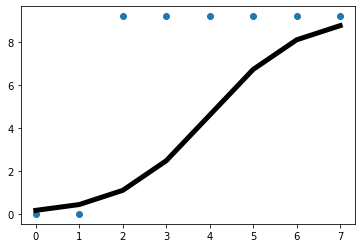

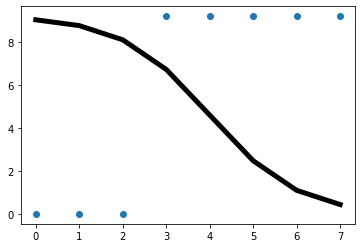

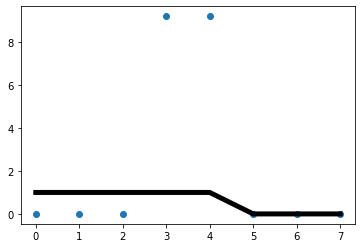

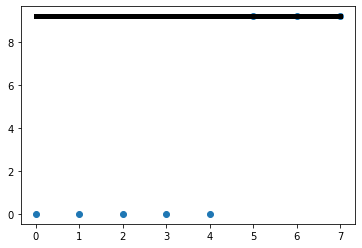

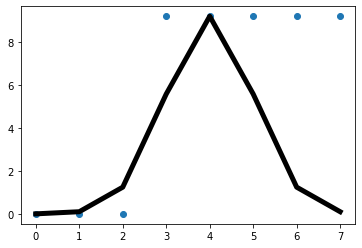

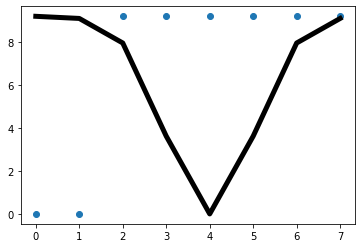

In [132]:
# Sampling
# torch.manual_seed(0)
song_index = 4
sample_melody = val_melody[song_index].unsqueeze(0)
sample_length = val_length[song_index]
sample_melody_framewise = np.expand_dims(val_melody_framewise[song_index],axis=0)
sample_chord_groundtruth_idx = np.expand_dims(val_chord_groundtruth_idx[song_index],axis=0)
sample_tempo = [tempos[song_index]]
sample_downbeat = [downbeats[song_index]]

true_surprise = np.array([])
pred_surprise = np.array([])

## Surprising profile
for type_num in range(1,7):
    s = profile_type(type_num,sample_length.item(),norm).profile[:sample_length]
    print(s.shape)
    true_surprise = np.concatenate((true_surprise,s.numpy()))

    pad = nn.ConstantPad2d((0, 272 - s.shape[0]), 0)
    surprise = pad(s).unsqueeze(0).unsqueeze(2)
    surprise = model_surp.surprise_embedding(surprise,sample_length.unsqueeze(0))
    latent_size = 16 * 4

    decoder_input = torch.cat([sample_melody, surprise],dim=-1)

    # for k in range(10):
    z = torch.randn(1,272,latent_size)
#     z = torch.cat([z,sample_melody,surprise], dim=-1)
    output, chord_pred = model_surp.decode(z,decoder_input)
#     output, chord_pred = model_surp.decode(z)
    gen_chord_index = torch.max(chord_pred[0],-1).indices[:sample_length]

    print(gen_chord_index)
    #     print(gen_chord_index.shape)
    print([INDICES_TO_SYMBOL[x] for x in gen_chord_index.numpy()])

    gen_chord_seq = torch.max(chord_pred[0],-1).indices.unsqueeze(0).unsqueeze(-1)
    ########## Surprise contours ###########
    all_chords = True
    surprisingness_seq, TM = markov_chain(gen_chord_seq,all_chords).create_surprisingness_seqs()
    surprisingness_seq[0][1] = 0
    pred_surprise = np.concatenate((pred_surprise,surprisingness_seq[0][:sample_length].squeeze()))

    fig, ax = plt.subplots()
    ax.plot(surprisingness_seq[0][:sample_length],'.',markersize=12)
    ax.plot(s,'k',linewidth=5)

    ########## Random sampling ###########
    # Proceed chord decode
    print('proceed chord decode...')
    joint_prob = chord_pred.cpu().detach().numpy()

    # Append argmax index to get pianoroll array
#     accompany_pianoroll = argmax2pianoroll(joint_prob)
    accompany_pianoroll = argmax2pianoroll_all(joint_prob)

    # augment chord into frame base
    BEAT_RESOLUTION = 24
    BEAT_PER_CHORD = 2

    accompany_pianoroll_framewise, sample_chord_groundtruth_framewise = sequence2frame(accompany_pianoroll, sample_chord_groundtruth_idx)

    # length into frame base
    sample_length_framewise = sample_length * BEAT_RESOLUTION * BEAT_PER_CHORD

    # write pianoroll
    result_dir = 'results/weight_surprising_cvae_all_chords'
    filename = str(song_index) + '-surprisingness-function-type-' + str(type_num)
    write_one_pianoroll(result_dir, filename, sample_melody_framewise, accompany_pianoroll_framewise, sample_chord_groundtruth_framewise, sample_length_framewise, sample_tempo, sample_downbeat)

# ########## granger causality ###########
# data = pd.DataFrame({
#                  'true_surprise': true_surprise, 
#                  'pred_surprise': pred_surprise
#                 }
#                )
# gc_res = grangercausalitytests(data, 4)